# Bart Webinar 4: Hands-on Exercise

In this exercise you will use BART with Python/NumPy prospectively under-sampled 2D k-space data. 

__Main references:__

Pruessmann KP, Weiger M, Scheidegger MB, Boesiger P. SENSE: sensitivity encoding for fast MRI. Magn Reson Med. 1999 Nov;42(5):952-62. PMID: 10542355.

Huang F, Vijayakumar S, Li Y, Hertel S, Duensing GR. A software channel compression technique for faster reconstruction with many channels. Magn Reson Imaging. 2008 Jan;26(1):133-41. doi: 10.1016/j.mri.2007.04.010. Epub 2007 Jun 15. PMID: 17573223.

Uecker M, Lai P, Murphy MJ, Virtue P, Elad M, Pauly JM, Vasanawala SS, Lustig M. ESPIRiT--an eigenvalue approach to autocalibrating parallel MRI: where SENSE meets GRAPPA. Magn Reson Med. 2014 Mar;71(3):990-1001. doi: 10.1002/mrm.24751. PMID: 23649942; PMCID: PMC4142121.


The general workflow of this notebook is as follows:- 
1. Import k-space data from hdf5 file. There are 2 separate arrays in the file: undersampled k-space data and a low-resolution reference scan with a fully sampled calibration region. 
1. Visualize the data for both the files in k-space and in image space
1. Perform coil-compression and estimate the sensitivity maps from the reference scan 
1. Use the sensitivity maps and the undersampled k-space data to reconstruct the image using parallel imaging

The data were collected on a 3 Tesla Siemens Vida scanner at UT Austin with IRB approval and informed consent.

**Authors**: [Sidharth Kumar](mailto:sidharth.kumar@utexas.edu), [Jon Tamir](mailto:jtamir@utexas.edu)  
**Institution**: UT Austin

### Prerequisites

Make sure the BART configuration is completed and these paths are set correctly.

`TOOLBOX_PATH=/Your/path/to/bart`

`PATH=$TOOLBOX_PATH:$PATH`

In addition to the more common scientific Python libraries, we will also use `h5py`. If you are missing it, uncomment the following cell

In [4]:
# !pip install h5py

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from bart import bart
import h5py
%matplotlib inline

## Load the data
Load the data to be used for reconstruction, the data have 2 separate files for undersampled k-space data and the fully sampled (only in calibration region) reference data.

In [6]:
with h5py.File('webinar4_exercise_data.h5', 'r') as F:
    ksp_und = np.array(F['ksp_und'])
    ksp_ref = np.array(F['ksp_ref'])
    
print('ksp_und shape:', ksp_und.shape)
print('ksp_ref shape:', ksp_ref.shape)

ksp_und shape: (288, 288, 1, 12)
ksp_ref shape: (47, 288, 1, 12)


## Resize the reference data
Bring the reference k-space data to the same shape as the undersampled k-space data so that the calculated sensitivity maps are of same dimension.

In [7]:
dim_ro = ksp_und.shape[0]
ksp_ref = bart(1,'resize -c 0 {}'.format(dim_ro), ksp_ref) # bring the reference scan to reqruied shape

print('ksp_und shape:', ksp_und.shape)
print('ksp_ref shape:', ksp_ref.shape)

ksp_und shape: (288, 288, 1, 12)
ksp_ref shape: (288, 288, 1, 12)


## Visualize the reference scan
Plot the k-space reference data and observe that only the centeral region have data. Also notice that the frequency encode direction is fully sampled and in the phase encode we only have samples in the central region.

Only showing the first 6 coils


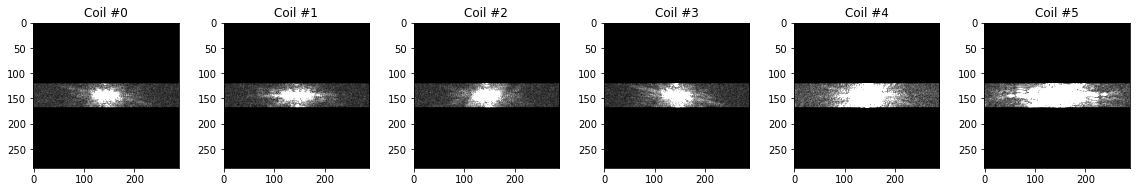

In [8]:
#visualize the ref scan kspace
fig, axes = plt.subplots(1, 6, figsize=(16, 8))
plt.tight_layout() # This automatically puts space between plots and make it tidy

for ax, index in zip(axes, range(12)):
    ax.imshow(np.abs(ksp_ref[...,index]),cmap='gray',vmax=.00001)
    ax.set_title('Coil #{}'.format(index))
print('Only showing the first 6 coils')

Now we will do an RSS reconstruction of the reference k-space data using the `bart fft` and `bart rss` commands

In [9]:
# do an ifft of the ref k-space data
cimg_ref = bart(1,'fft -i -u 3', ksp_ref)
print(cimg_ref.shape)

(288, 288, 1, 12)


Plot the calibration images, and observe the low resolution in these images.

Only showing the first 6 coils


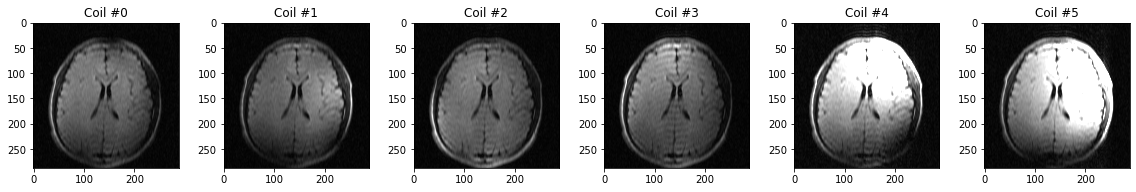

In [10]:
#visualize the calibration images
fig, axes = plt.subplots(1, 6, figsize=(16, 8))
plt.tight_layout() # This automatically puts space between plots and make it tidy

for ax, index in zip(axes, range(12)):
    ax.imshow(np.abs(cimg_ref[...,index]),cmap='gray',vmax=.00003)
    ax.set_title('Coil #{}'.format(index))
print('Only showing the first 6 coils')

Reconstruct the reference RSS (root sum of squares) image and plot it. You can observe the low resolution and the ringing in the reconstructed image

Text(0.5, 1.0, 'Reference scan RSS')

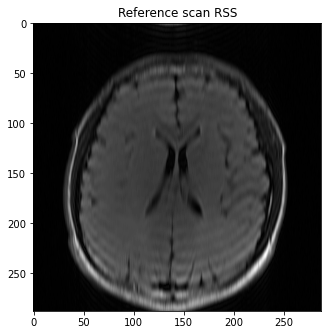

In [11]:
rss_ref = bart(1, 'rss 8', cimg_ref)

# visualize the RSS image
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
ax.imshow(np.abs(rss_ref),cmap='gray')
ax.set_title('Reference scan RSS')

## PICS scale factor
The parallel imaging and compressed sensing, `bart pics` command typically scales the k-space data so that the RSS image has maximum value close to one. This is so that the regularization factor is more consistent across different input datasets. 

The scale factor is choosen as the 99th percentile of the magnitude of the RSS reference scan.
```python
scale_factor = np.percentile(abs(rss_acs), 99)
```
where `np.percentile` selects the 99th percentile and `rss_acs` is the RSS reconstruction of a fully sampled calibration region in the data.

When a separate reference scan is used for calibration, it is useful to manually pass the scale factor to the `pics` command since it will not be able to automatically compute it from the under-sampled data.

In [12]:
# get the scale factor from the reference data
scale_factor = np.percentile(abs(rss_ref), 99)
print('Scale factor: {:.5f}'.format(scale_factor))

Scale factor: 0.00024


## Plot and observe the under-sampled k-space data
Now we will look at the under-sampled data.

Only showing the first 6 coils


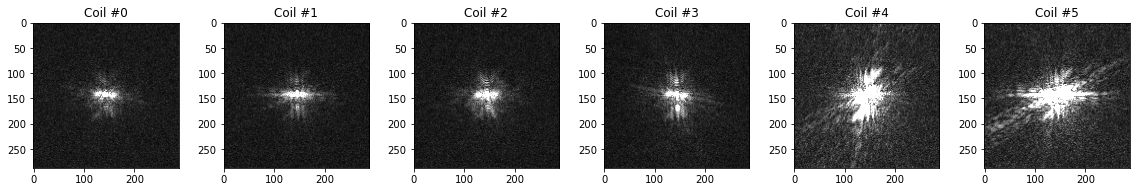

In [13]:
# undersampled k-space data of the main image
fig, axes = plt.subplots(1, 6, figsize=(16, 8))
plt.tight_layout() # This automatically puts space between plots and make it tidy

for ax, index in zip(axes, range(12)):
    ax.imshow(np.abs(ksp_und[...,index]),cmap='gray',vmax=.00001)
    ax.set_title('Coil #{}'.format(index))
print('Only showing the first 6 coils')

## Calculate sampling pattern
In the above k-space plots, the undersampling is not clearly observed, hence we will create a mask from the undersampled k-space data using the `bart pattern` command. Further calculate the accelaration factor and plot the mask to observe that indeed the kspace data is undersampled.

Text(0.5, 1.0, 'Acceleration Factor: R=2.00')

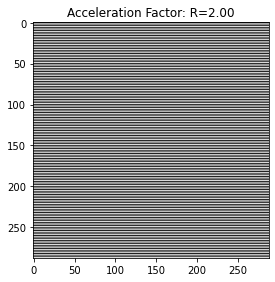

In [14]:
# calculate the sampling pattern
mask = bart(1, 'pattern', ksp_und).real
R = np.prod(np.shape(mask)) / np.sum(mask) # acceleration factor

fig, axes = plt.subplots(1, 1, figsize=(4, 4))
plt.tight_layout() # This automatically puts space between plots and make it tidy
axes.imshow(mask, cmap='gray')
plt.title('Acceleration Factor: R={:.2f}'.format(R))


## Visualize the under-sampled data in the image domain
Take a ifft of the undersampled data using the bart fft command with required flags and plot the images for different coils, you should be able to see the aliasing in the different coil images, however all of them are high resolution. 

In [15]:
#take a naive ifft
cimg_und = bart(1,'fft -i -u 3', ksp_und)
print(cimg_und.shape)

(288, 288, 1, 12)


Only showing the first 6 coils


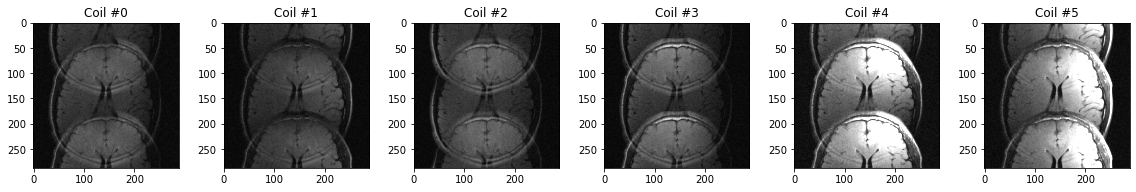

In [16]:
#visualize the aliased images
fig, axes = plt.subplots(1, 6, figsize=(16, 8))
plt.tight_layout() # This automatically puts space between plots and make it tidy

for ax, index in zip(axes, range(12)):
    ax.imshow(np.abs(cimg_und[...,index]),cmap='gray',vmax=.00003)
    ax.set_title('Coil #{}'.format(index))
print('Only showing the first 6 coils')

## RSS reconstruction
Perform an RSS reconstruction of the under-sampled coil images and plot it. You can observe the high resolution aliased imaged of brain. 

Text(0.5, 1.0, 'Under-sampled RSS')

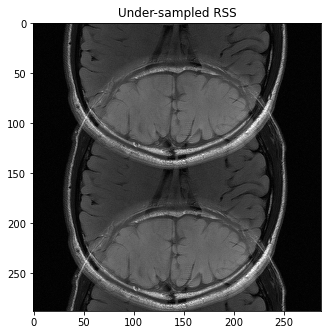

In [17]:
# visualize the RSS image
rss_und = bart(1, 'rss 8', cimg_und)

fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
ax.imshow(np.abs(rss_und),cmap='gray')
ax.set_title('Under-sampled RSS')

## Coil Compression
Before reconstucting, we will coil-compress the coils using the Software Coil Compression method.

First calculate the coil compression matrix using `bart cc` command on the reference scan data. Then project the reference scan and the under-sampled k-space data using `bart ccapply` command to the desired number of virtual coils (we recommend about 8) for this data. To see more information about any of these commands use "!bart cc -h" in a new cell

In [18]:
# run coil compression to get coil compression matrix
cc_matrix = bart(1, 'bart cc -M', ksp_ref)
print(cc_matrix.shape)

(1, 1, 1, 12, 12)


In [19]:
# apply coil compression to num_vcoils  virtual coils -- apply to ref and to kspace data!
num_vcoils = 8
ksp_cc_ref = bart(1, 'ccapply -p {}'.format(num_vcoils), ksp_ref, cc_matrix)
ksp_cc_und = bart(1, 'ccapply -p {}'.format(num_vcoils), ksp_und, cc_matrix)
print(ksp_cc_ref.shape)
print(ksp_cc_und.shape)

(288, 288, 1, 8)
(288, 288, 1, 8)


In [20]:
#bart ecalib help
!bart ecalib -h

WARN: BART version is not reproducible.
Usage: ecalib [-t f] [-c f] [-k d:d:d] [-r d:d:d] [-m d] [-S] [-W] [-I] [-1] [-P] [-v f] [-a] [-d d] <kspace> <sensitivities> [<ev-maps>] 

Estimate coil sensitivities using ESPIRiT calibration.
Optionally outputs the eigenvalue maps.

-t threshold     This determined the size of the null-space.
-c crop_value    Crop the sensitivities if the eigenvalue is smaller than {crop_value}.
-k ksize         kernel size
-r cal_size      Limits the size of the calibration region.
-m maps          Number of maps to compute.
-S               create maps with smooth transitions (Soft-SENSE).
-W               soft-weighting of the singular vectors.
-I               intensity correction
-1               perform only first part of the calibration
-P               Do not rotate the phase with respect to the first principal component
-v variance      Variance of noise in data.
-a               Automatically pick thresholds.
-d level         Debug level
-h          

## Coil sensitvity map calibration
Use `bart ecalib` command to estimate the coil sensitivities from the coil compressed reference k-space data and plot the coil sensitivity maps.

In [21]:
# estimate the coil sensitivities
coil_sens, ev_maps= bart(2, 'ecalib -a -m 1', ksp_cc_ref) # estimate coil sensitivities using the Auto-ESPIRiT algorithm
print(coil_sens.shape)

(288, 288, 1, 8)


coil sensitivity maps


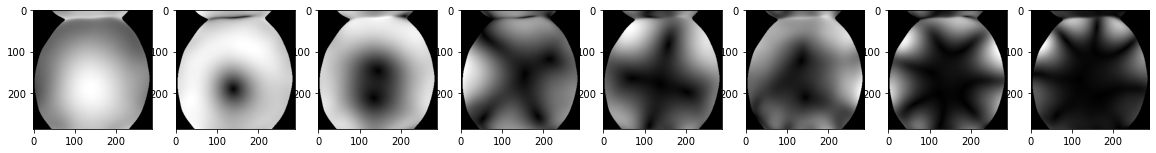

In [22]:
# visvualize the estimated coil sensitivities
plt.figure(figsize=(20,6))
for index in range(num_vcoils):
    plt.subplot(1,num_vcoils,index+1)
    plt.imshow(np.abs(coil_sens[..., index]),cmap='gray')
print('coil sensitivity maps')

## Reconstruction
Reconstruct the image using bart parallel imaging command `bart pics`, specifically run the help command and observe which flags do you require for regularation options, manually scaling of the data and how to give the inputs. 
Plot the reconstructed image and observe that the aliasing is removed and you can see a high resolution T2-FLAIR image of brain.

In [23]:
#bart pics command help
# !bart pics -h

In [24]:
# reconstruct the image using bart parallel imaging command
l2_reg = 1e-4
reco_l2 = bart(1, 'pics -w {} -R Q:{} -S'.format(scale_factor, l2_reg), ksp_cc_und, coil_sens)
print(reco_l2.shape)

(288, 288)


Text(0.5, 1.0, 'T2 FLAIR reconstructed')

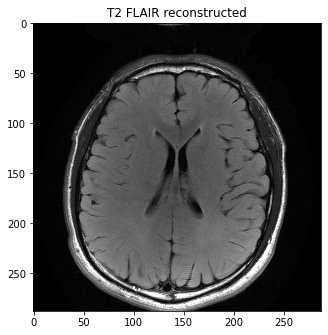

In [25]:
# visualize the reconstructed T2-FLAIR image
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
ax.imshow(np.abs(reco_l2), cmap='gray', vmax=.0003)
ax.set_title('T2 FLAIR reconstructed')

## (Extra credits) Undersampling by an additional factor of 2
In simulation undersampling can be performed in both the directions i.e. phase and frequency encode. However on actual scanner, the frequency encode direction is always fully sampled. Therefore we will further undersample the phase encode direction by a factor of 2

In [22]:
ksp_cc_und_4x = np.zeros((ksp_cc_und.shape),dtype=complex)
ksp_cc_und_4x[1::4,...] = ksp_cc_und[1::4,...] #undersampling in the phase encode direction
# ksp_cc_und_4x[:,1::2,:] = ksp_cc_und[:,1::2,:] #undersampling in the frequency encode direction

### Take a ifft of the undersampled data using the bart fft command with required flags and plot the images for different coils, you should be able to see the aliasing in the different coil images, however all of them are still high resolution. 

In [23]:
#take a naive ifft
cimg_und_4x = bart(1,'fft -i -u 3', ksp_cc_und_4x)
print(cimg_und_4x.shape)

(288, 288, 1, 8)


Only showing the first 6 coils


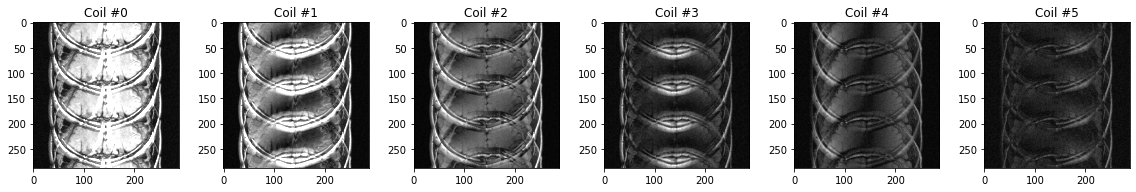

In [24]:
#visualize the aliased images
fig, axes = plt.subplots(1, 6, figsize=(16, 8))
plt.tight_layout() # This automatically puts space between plots and make it tidy

for ax, index in zip(axes, range(12)):
    ax.imshow(np.abs(cimg_und_4x[...,index]),cmap='gray',vmax=.00003)
    ax.set_title('Coil #{}'.format(index))
print('Only showing the first 6 coils')

### Reconstruct the reference RSS (root sum of squares) image and plot it. You can observe the high resolution aliased imaged of brain. 

Text(0.5, 1.0, 'Under-sampled RSS')

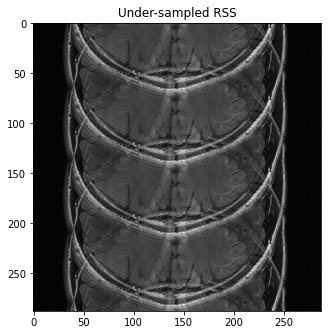

In [25]:
# visualize the RSS image
rss_und_4x = bart(1, 'rss 8', cimg_und_4x)

fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
ax.imshow(np.abs(rss_und_4x),cmap='gray')
ax.set_title('Under-sampled RSS')

### Create a mask from the undersampled k-space data using the bart pattern command for the 4x undersampling. Further calculate the accelaration factor and plot the mask to observe that indeed the kspace data is undersampled.

Text(0.5, 1.0, 'Acceleration Factor: R=4.00')

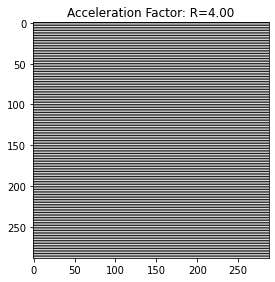

In [26]:
# calculate the sampling pattern
mask_4x = bart(1, 'pattern', ksp_cc_und_4x).real
R_4x = np.prod(np.shape(mask_4x)) / np.sum(mask_4x) # acceleration factor

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plt.tight_layout() # This automatically puts space between plots and make it tidy
ax.imshow(mask, cmap='gray')
plt.title('Acceleration Factor: R={:.2f}'.format(R_4x))

### Reconstruct the image using bart parallel imaging command "pics". 
Plot the reconstructed image and observe that the aliasing is removed and you can see a high resolution T2-FLAIR image of brain. However the final image for 4x undersampling is not as good as the one for the 2x undersampling. Think about what could be possible reasons for this behaviour. 

In [27]:
# reconstruct the image using bart parallel imaging command
l2_reg_4x = l2_reg
reco_l2_4x = bart(1,'pics -w {} -R Q:{}  -S'.format(scale_factor, l2_reg_4x), ksp_cc_und_4x, coil_sens)
print(reco_l2_4x.shape)

(288, 288)


Text(0.5, 1.0, 'T2 FLAIR 4X reconstructed')

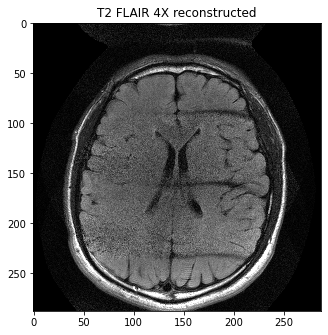

In [28]:
# visualize the reconstructed T2-FLAIR image
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
ax.imshow(np.abs(reco_l2_4x), cmap='gray', vmax=.0003)
ax.set_title('T2 FLAIR 4X reconstructed')